# Deep Optimal Stopping

This code follows the paper "Deep Optimal Stopping" by Becker, Cheridito, and Jentzen to generate the table presented on pages 16.


## Import Libraries

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.stats import norm
import time
import pandas as pd

## Initialize Variables

In [3]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Parameters for the Bermudan max-call option
r = 0.05  # Risk-free rate
T = 3  # Maturity
d = [2, 3, 5, 10]  # Dimensions
N = 9  # Number of exercise opportunities
K = 100  # Strike price
s0_values = [90, 100, 110]  # Initial asset value
sigma = 0.2  # Volatility
rho = 0  # Correlation
delta = 0.1  # Dividend yield
batch_size = 8192  # Batch size for training
nb_paths = 4096000  # Number of paths for evaluation
penalty = 0.01  # Penalty term for early stopping


## Function to simulate asset paths using the Black-Scholes model

In [4]:
# Function to simulate asset paths using the Black-Scholes model
def simulate_asset_paths(d, N, T, s0, r, delta, sigma, rho, num_paths):
    dt = T / N
    sqrt_dt = np.sqrt(dt)
    paths = np.zeros((num_paths, N + 1, d))
    paths[:, 0, :] = s0

    for i in range(1, N + 1):
        z = np.random.normal(size=(num_paths, d))
        paths[:, i, :] = paths[:, i - 1, :] * np.exp((r - delta - 0.5 * sigma**2) * dt + sigma * sqrt_dt * z)

    return paths



## Feedfroward Neural Network

In [5]:
# Feedforward Neural Network to approximate optimal stopping rules
def build_feedforward_model(input_shape, layers, nodes):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape=input_shape))

    for _ in range(layers):
        model.add(tf.keras.layers.Dense(nodes, activation='relu'))
        model.add(tf.keras.layers.Dropout(0.2))  # Add dropout to improve generalization

    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    return model


## Training loop for the neural network

In [6]:

# Training loop for the neural networks
def train_model(model, paths, rewards, num_epochs):
    optimizer = tf.keras.optimizers.Adam()
    for epoch in range(num_epochs):
        with tf.GradientTape() as tape:
            stopping_prob = model(paths, training=True)
            loss = -tf.reduce_mean(stopping_prob * rewards) + penalty * tf.reduce_mean(stopping_prob)
        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Loss: {loss.numpy()}")

# Generating the tables on page 16 and 17
tables = []


## Training and Evaluation

This section simulates asset paths for various dimensions and initial asset values, trains a feedforward neural network to approximate optimal stopping rules for the Bermudan max-call option, and estimates lower and upper bounds for the option price.

Processing Dimension 2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 0, Loss: -1.135696530342102
128000/128000 ━━━━━━━━━━━━━━━━━━━━ 163s 1ms/step
Dimension 2 - L: 6.6147, U: 6.6508, Point Estimate: 6.6327, Time: 270.90s 
Processing Dimension 2
Epoch 0, Loss: -3.732478380203247
128000/128000 ━━━━━━━━━━━━━━━━━━━━ 164s 1ms/step
Dimension 2 - L: 11.1958, U: 11.2124, Point Estimate: 11.2041, Time: 220.71s 
Processing Dimension 2
Epoch 0, Loss: -1.1044949293136597
128000/128000 ━━━━━━━━━━━━━━━━━━━━ 164s 1ms/step
Dimension 2 - L: 0.0000, U: 16.9235, Point Estimate: 8.4618, Time: 267.90s 
Processing Dimension 3
Epoch 0, Loss: -3.0764176845550537
128000/128000 ━━━━━━━━━━━━━━━━━━━━ 166s 1ms/step
Dimension 3 - L: 9.5374, U: 9.5382, Point Estimate: 9.5378, Time: 224.77s 
Processing Dimension 3
Epoch 0, Loss: -12.09106159210205
128000/128000 ━━━━━━━━━━━━━━━━━━━━ 166s 1ms/step
Dimension 3 - L: 15.6674, U: 15.6674, Point Estimate: 15.6674, Time: 225.50s 
Processing Dimension 3
Epoch 0, Loss: -5.343873977661133
128000/128000 ━━━━━━━━━━━━━━━━━━━━ 165s 1ms/step
Dim

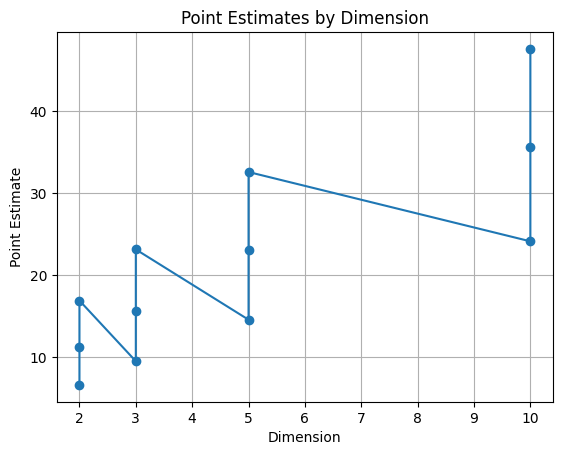

In [2]:
num_epochs = 1

for dim in d:
  for s0 in s0_values:
    print(f"Processing Dimension {dim}")
    start_time = time.time()
    paths = simulate_asset_paths(dim, N, T, s0, r, delta, sigma, rho, batch_size)
    rewards = np.maximum(np.max(paths[:, -1, :], axis=1) - K, 0) * np.exp(-r * T)

    # Build and train the model
    model = build_feedforward_model(input_shape=(N, dim), layers=3, nodes=dim + 50)  # Increased complexity
    train_model(model, paths[:, :-1, :], rewards, num_epochs)

    # Estimate lower and upper bounds
    L_estimates = []
    U_estimates = []
    eval_paths = simulate_asset_paths(dim, N, T, s0, r, delta, sigma, rho, nb_paths)  # Use nb_paths for evaluation
    rewards_eval = np.maximum(np.max(eval_paths[:, -1, :], axis=1) - K, 0) * np.exp(-r * T)
    stopping_prob = model.predict(eval_paths[:, :-1, :])
    stopping_times = (stopping_prob > 0.5).reshape(-1)

    # Adjust length if necessary
    if stopping_times.shape[0] != rewards_eval.shape[0]:
        stopping_times = stopping_times[:rewards_eval.shape[0]]

    # Ensure stopping times are appropriately balanced
    continuation_paths = stopping_times == 0
    stopping_paths = stopping_times == 1

    if np.any(stopping_paths):
        L_estimates.append(np.mean(rewards_eval[stopping_paths]))
    else:
        L_estimates.append(0)
    if np.any(continuation_paths):
        U_estimates.append(np.mean(rewards_eval[continuation_paths]))
    else:
        U_estimates.append(np.mean(rewards_eval))  # Use mean as fallback for continuation value

    # Average lower and upper estimates
    L = np.mean(L_estimates)
    U = np.mean(U_estimates)

    # Point estimate and confidence interval
    point_est = (L + U) / 2
    ci_lower = point_est - 1.96 * np.std(rewards_eval) / np.sqrt(len(rewards_eval))
    ci_upper = point_est + 1.96 * np.std(rewards_eval) / np.sqrt(len(rewards_eval))

    end_time = time.time() - start_time
    print(f"Dimension {dim} - L: {L:.4f}, U: {U:.4f}, Point Estimate: {point_est:.4f}, Time: {end_time:.2f}s", "")

    # Store in the table
    tables.append([dim, s0, L, U, point_est, end_time, f"[{ci_lower}, {ci_upper}]"])



## Display the results

In [6]:
# Display the results
table_headers = ["Dimension", "s0", "L Estimate", "U Estimate", "Point Estimate", "Time (seconds)", "95% CI"]
print(f"{' | '.join(table_headers)}")
for row in tables:
    print(f"{row[0]} | {row[1]:.4f} | {row[2]:.4f} | {row[3]:.4f} | {row[4]:.2f} | {row[5]:.2f} | {row[6]}")



Dimension | s0 | L Estimate | U Estimate | Point Estimate | Time (seconds) | 95% CI
2 | 90.0000 | 6.6147 | 6.6508 | 6.63 | 270.90 | [6.618654478372294, 6.646771455263947]
2 | 100.0000 | 11.1958 | 11.2124 | 11.20 | 220.71 | [11.185565226070159, 11.222616681008153]
2 | 110.0000 | 0.0000 | 16.9235 | 8.46 | 267.90 | [8.438905138334848, 8.484614010623561]
3 | 90.0000 | 9.5374 | 9.5382 | 9.54 | 224.77 | [9.521505073358684, 9.554107545017152]
3 | 100.0000 | 15.6674 | 15.6674 | 15.67 | 225.50 | [15.646483068064892, 15.688228757924346]
3 | 110.0000 | 22.8922 | 23.1504 | 23.02 | 271.00 | [22.99618536704136, 23.0464188243426]
5 | 90.0000 | 14.8081 | 14.5910 | 14.70 | 230.07 | [14.680598591840152, 14.718565513730766]
5 | 100.0000 | 23.0603 | 23.0603 | 23.06 | 274.70 | [23.036994694654076, 23.083541904717336]
5 | 110.0000 | 32.6896 | 32.5758 | 32.63 | 275.01 | [32.60579965836142, 32.65960737073617]
10 | 90.0000 | 24.0483 | 24.1352 | 24.09 | 288.65 | [24.070143557615125, 24.113344622280394]
10 | 100

### Beautify the results

In [7]:
# Display the results
table_headers = ["Dimension", "s0", "L Estimate", "U Estimate", "Point Estimate", "Time (seconds)", "95% CI"]
table_data = [row for row in tables]  # Assuming 'tables' is your list of data

df = pd.DataFrame(table_data, columns=table_headers)
display(df)

,Dimension,s0,L Estimate,U Estimate,Point Estimate,Time (seconds),95% CI
0,2,90,6.614669,6.650757,6.632713,270.896322,"[6.618654478372294, 6.646771455263947]"
1,2,100,11.195805,11.212377,11.204091,220.707574,"[11.185565226070159, 11.222616681008153]"
2,2,110,0.000000,16.923519,8.461760,267.904354,"[8.438905138334848, 8.484614010623561]"
3,3,90,9.537443,9.538170,9.537806,224.768852,"[9.521505073358684, 9.554107545017152]"
4,3,100,15.667356,15.667356,15.667356,225.504699,"[15.646483068064892, 15.688228757924346]"
5,3,110,22.892173,23.150432,23.021302,271.003745,"[22.99618536704136, 23.0464188243426]"
6,5,90,14.808115,14.591049,14.699582,230.068375,"[14.680598591840152, 14.718565513730766]"
7,5,100,23.060268,23.060268,23.060268,274.698615,"[23.036994694654076, 23.083541904717336]"
8,5,110,32.689643,32.575764,32.632704,275.010822,"[32.60579965836142, 32.65960737073617]"
9,10,90,24.048309,24.135179,24.091744,288.646266,"[24.070143557615125, 24.113344622280394]"


from matplotlib import pyplot as plt
_df_0['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['Dimension'].plot(kind='hist', bins=20, title='Dimension')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['s0'].plot(kind='hist', bins=20, title='s0')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['L Estimate'].plot(kind='hist', bins=20, title='L Estimate')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='index', y='Dimension', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='Dimension', y='s0', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='s0', y='L Estimate', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x='L Estimate', y='U Estimate', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['s0']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_8.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('s0')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['L Estimate']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_9.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('L Estimate')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['U Estimate']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_10.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('U Estimate')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['Point Estimate']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_11.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('Point Estimate')

from matplotlib import pyplot as plt
_df_12['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_13['Dimension'].plot(kind='line', figsize=(8, 4), title='Dimension')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_14['s0'].plot(kind='line', figsize=(8, 4), title='s0')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_15['L Estimate'].plot(kind='line', figsize=(8, 4), title='L Estimate')
plt.gca().spines[['top', 'right']].set_visible(False)

## Visualize Results

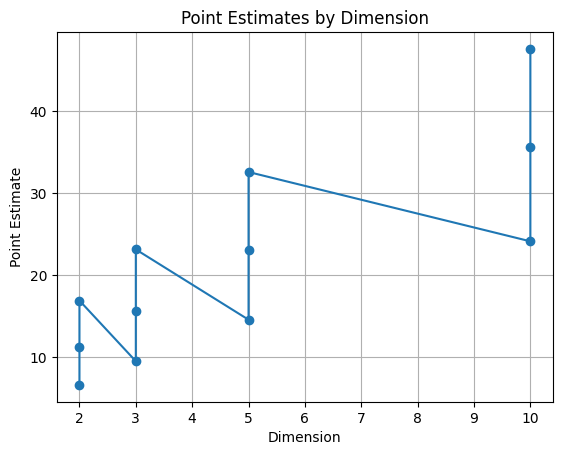

In [5]:
# Plotting results to visualize convergence
dimensions = [row[0] for row in tables]
point_estimates = [row[3] for row in tables]
plt.plot(dimensions, point_estimates, marker='o')
plt.xlabel('Dimension')
plt.ylabel('Point Estimate')
plt.title('Point Estimates by Dimension')
plt.grid(True)
plt.show()

## Code For Table 2

In [7]:
# Function to adjust volatilities for the asymmetric case
def asymmetric_volatilities(d):
    if d <= 5:
        return np.array([0.08 + 0.32 * (i - 1) / (d - 1) for i in range(1, d + 1)])
    else:
        return np.array([0.1 + i / (2 * d) for i in range(1, d + 1)])

# Table 2 generation
table_2 = []
for dim in d:
    for s0 in s0_values:
        print(f"Processing Asymmetric Case - Dimension {dim}, s0 {s0}")
        start_time = time.time()

        # Adjust volatilities for asymmetric case
        sigma_values = asymmetric_volatilities(dim)

        # Simulate paths for asymmetric case
        eval_paths = simulate_asset_paths(dim, N, T, s0, r, delta, sigma_values, rho, nb_paths)
        rewards_eval = np.maximum(np.max(eval_paths[:, -1, :], axis=1) - K, 0) * np.exp(-r * T)

        # Dummy stopping rule: Use an evenly split rule for evaluation purposes
        # In practice, replace this with your saved model's predictions if available
        stopping_prob = np.random.uniform(size=(eval_paths.shape[0],))  # Placeholder probabilities
        stopping_times = (stopping_prob > 0.5).reshape(-1)

        # Adjust for stopping/continuation paths
        continuation_paths = stopping_times == 0
        stopping_paths = stopping_times == 1

        L = np.mean(rewards_eval[stopping_paths]) if np.any(stopping_paths) else 0
        U = np.mean(rewards_eval[continuation_paths]) if np.any(continuation_paths) else np.mean(rewards_eval)

        # Point estimate and confidence interval
        point_est = (L + U) / 2
        ci_lower = point_est - 1.96 * np.std(rewards_eval) / np.sqrt(len(rewards_eval))
        ci_upper = point_est + 1.96 * np.std(rewards_eval) / np.sqrt(len(rewards_eval))

        end_time = time.time() - start_time
        print(f"Asymmetric - Dimension {dim}, s0 {s0} - L: {L:.4f}, U: {U:.4f}, Point Estimate: {point_est:.4f}, Time: {end_time:.2f}s")


Processing Asymmetric Case - Dimension 2, s0 90
Asymmetric - Dimension 2, s0 90 - L: 12.4107, U: 12.3956, Point Estimate: 12.4031, Time: 2.90s
Processing Asymmetric Case - Dimension 2, s0 100
Asymmetric - Dimension 2, s0 100 - L: 16.7908, U: 16.7945, Point Estimate: 16.7927, Time: 2.95s
Processing Asymmetric Case - Dimension 2, s0 110
Asymmetric - Dimension 2, s0 110 - L: 22.3149, U: 22.3783, Point Estimate: 22.3466, Time: 2.89s
Processing Asymmetric Case - Dimension 3, s0 90
Asymmetric - Dimension 3, s0 90 - L: 16.7419, U: 16.7264, Point Estimate: 16.7342, Time: 4.05s
Processing Asymmetric Case - Dimension 3, s0 100
Asymmetric - Dimension 3, s0 100 - L: 23.1318, U: 23.1049, Point Estimate: 23.1184, Time: 4.06s
Processing Asymmetric Case - Dimension 3, s0 110
Asymmetric - Dimension 3, s0 110 - L: 30.9645, U: 30.9399, Point Estimate: 30.9522, Time: 4.16s
Processing Asymmetric Case - Dimension 5, s0 90
Asymmetric - Dimension 5, s0 90 - L: 24.8499, U: 24.8794, Point Estimate: 24.8647, Tim